# Code-Snippets for PyTorch

## PyTest
Nice functionality to run test-cases on certain modules of your model.
Add the following content to a Python file and name it starting with 'test\_'. 
Every test function name will also begin with 'test\_'.

#### Parametrize
One can parametrize the test cases so they won't need to be 'copied' multiple times. Notice the 3 parameters provided in the decorator and their values as a list of tuples.

In [9]:
import pytest

def sum(a, b):
    return a + b

def pow(base, exponent):
    return base ** exponent

@pytest.mark.parametrize('a, b, expected',[
    (1,2,3),
    (4,5,9),
    (3,4,7)
])
def test_sum(a, b, expected):
    assert sum(a,b) == expected

#### Fixtures
Used for executing a step before the testing can commence. Notice the syntax of the decorator below. The function that is decorated with a fixture is something that will be executed whenever that function name is supplied as an argument to a test function. The return value substitutes for the argument of the test function.

In [ ]:
@pytest.fixture
def base():
    return 4

def test_pow(base):
    assert pow(base,1) == 4

#### Execution
Use the following command in the same directory as the above Python file. The flag '-v' indicates that a verbose output be shown.

In [ ]:
!pytest -v

## Progress Logging
Use one of the following functions to print the progress during training.
### Batch Progress Bar

In [16]:
def batch_progress_bar(batch_num, report_interval, last_loss):
    """Prints the progress until the next report."""
    progress = (((batch_num-1.0) % report_interval) + 1.0) / report_interval
    fill = int(progress * 40)
    print "\r\tBATCH [{}{}]: {} (Loss: {:.4f})".format(
        "=" * fill, 
        " " * (40 - fill), 
        batch_num, 
        last_loss)

batch_progress_bar(40,100,334.23)
batch_progress_bar(45,100,334.23)

	BATCH [================                        ]: 40 (Loss: 334.2300)
	BATCH [==================                      ]: 45 (Loss: 334.2300)


### Epoch Progress Bar

In [17]:
def epoch_progress_bar(epoch_num, total_epochs, train_loss, test_loss):
    """Prints the progress until the next report."""
    progress = (((epoch_num-1.0) % total_epochs) + 1.0) / total_epochs
    fill = int(progress * 40)
    print "\rEPOCH [{}{}]: {} (Avg. Training Loss: {:.4f}) (Test Loss: {:.4f})".format(
        "=" * fill, 
        " " * (40 - fill), 
        epoch_num, 
        train_loss,
        test_loss
    )

epoch_progress_bar(24,100,334.23,352.45)
epoch_progress_bar(30,100,334.23,352.45)

EPOCH [=========                               ]: 24 (Avg. Training Loss: 334.2300) (Test Loss: 352.4500)
EPOCH [============                            ]: 30 (Avg. Training Loss: 334.2300) (Test Loss: 352.4500)


### Saving

In [1]:
def save_checkpoint_for_batch(checkpoint_path,
                              model,
                              name,
                              seed,
                              epoch_num,
                              batch_num,
                              losses,
                              costs,
                              seq_lengths):
    basename = "{}/{}-{}-epoch-{}-batch-{}".format(checkpoint_path, name, seed, epoch_num, batch_num)
    model_fname = basename + ".model"
    LOGGER.info("Saving model checkpoint to: '%s'", model_fname)
    torch.save(model.state_dict(), model_fname)

    # Save the training history for batch
    train_fname = basename + ".json"
    LOGGER.info("Saving model training history to '%s'", train_fname)
    content = {
        "loss": losses,
        "cost": costs,
        "seq_lengths": seq_lengths
    }
    open(train_fname, 'wt').write(json.dumps(content))

### Loading
-- To be added --

## Gradient Tricks
### Clipping
Clips the the gradient to lie within a range.

In [ ]:
def clip_grads(model, range):
    """Gradient clipping to the range."""
    parameters = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in parameters:
        p.grad.data.clamp_(-range, range)

## Indexing Conventions
### Indexing in Sequential Data
In this section, we'll look at how to organise sequential data in a tensor in order for it to be a proper input to the model.
There are 3 dimensions of interest in the input tensor.
1. Sequence length: length of the sequence, say, in terms of time or time-steps.
2. Batch size: number of sequences to process in a batch
3. Input size: size of the input vector per time-step


We'll typically follow the above convention for the input data tensor. To justify this, we enumerate some nice properties that our input data tensor should have.
1. Data for each time-step will be processed one after the other by the same model-cell. Model-cell here refers to any generic neural network cell that processes data for one time-step such as a simple LSTM cell or something more complicated like a NTM cell. We typically want to call the model-cell in a loop for input tensors of every time step. This loop is the outer-most artifact in the code-organisation and hence time-step should be the 0th dimension of the input data tensor.
2. At a given time-step, when the model-cell is processing a sub-tensor, we'd like to have its 0th dimension as the dimension for the batch index and the 1st dimension as the dimension to index over entries of the input vector.


As is evident, the preceding order of dimensions aligns nicely with our requirements and hence would be our convention in ordering our indexes.

In [13]:
import torch
from torch import nn

# number of timesteps
num_timesteps = 10

# number of input vectors per batch
batch_size = 20

# size of each input vector
inp_dim = 30

# size of each input vector
outp_dim = 2

# instantiating the input data tensor
X = torch.randn(num_timesteps, batch_size, inp_dim)
print 'X.size()', X.size()

# instantiating a simple model cell
model_cell = nn.Linear(inp_dim, outp_dim)

# calling the model in a loop over timesteps
for t in range(num_timesteps):
    x = X[t] #sub-tensor for this timestep
    print 't =',t, '\tx.size()', x.size()
    y = model_cell(x)
    print 't =',t, '\ty.size()', y.size(), '\n'

X.size() torch.Size([10, 20, 30])
t = 0 	x.size() torch.Size([20, 30])
t = 0 	y.size() torch.Size([20, 2]) 

t = 1 	x.size() torch.Size([20, 30])
t = 1 	y.size() torch.Size([20, 2]) 

t = 2 	x.size() torch.Size([20, 30])
t = 2 	y.size() torch.Size([20, 2]) 

t = 3 	x.size() torch.Size([20, 30])
t = 3 	y.size() torch.Size([20, 2]) 

t = 4 	x.size() torch.Size([20, 30])
t = 4 	y.size() torch.Size([20, 2]) 

t = 5 	x.size() torch.Size([20, 30])
t = 5 	y.size() torch.Size([20, 2]) 

t = 6 	x.size() torch.Size([20, 30])
t = 6 	y.size() torch.Size([20, 2]) 

t = 7 	x.size() torch.Size([20, 30])
t = 7 	y.size() torch.Size([20, 2]) 

t = 8 	x.size() torch.Size([20, 30])
t = 8 	y.size() torch.Size([20, 2]) 

t = 9 	x.size() torch.Size([20, 30])
t = 9 	y.size() torch.Size([20, 2]) 



Notice that:
1. The loop is run over the timesteps and it is convenient for time-step to be the first dimension.
2. Size of X[t] or x is (20,30) where 20 is the number of batches and 30 is the length of the input vector.
3. Size of y for any time-step t is (20,2) where 20 is the number of batches and 2 is the length of the output vector. Hence we can take-away that (batch_idx, inp_dim) is the convention that is followed by the pre-written modules of PyTorch.

### Nuances of Squeeze and Unsqueeze

Any pre-defined module in PyTorch would consume a tensor of a fixed dimensionality. To comply with this, you have to massage your tensor to have the exact same size as defined by the PyTorch documentations. Furthermore, each dimension itself must represent what it ideally should according to the PyTorch documentations.

- **Example 1:** An LSTM module consumes as input a 3 dimensional tensor with each dimension meaning *(sequence, batch, values)*. Suppose you were interested in processing just one time-step and you actually had a 2D tensor having *(batch, values)*. In this case, you would **unsqueeze** the 2D tensor **at the dimension 0** to result in a 3D tensor such that the first dimension represents time-steps with just one time-step entry in it.
- **Example 2:** An LSTM module's output is a 3 dimensional tensor with the dimensions standing for *(sequence, batch, values)*. Suppose you gave the input as a 3D tensor for just one time step as exemplified in the above Example 1. But after getting the output, you want to do other things with the output and the 3D output tensor having semantics *(sequence, batch, values)* seems a bit cumbersome because the *sequence* dimension is just size 1 since we are dealing with just one time step. So we'd use squeeze to strip it off.

## About Batches and Epochs

1. When the **training data is too small** and you still decide to train a deep network, you may not want to bother with batches at all. Essentially, each iteration would consider the entire training data and each iteration will be like an epoch. So epoch as a term loses its meaning.
2. When the **training data is big but limited**, then you want to run each iteration in batches and you still want to see the entire data set more than once in the form of epochs.
3. When the **training data is unlimited**, which happens when you are synthetically generating the data, then you many not want to bother with epochs at all. You can just call up a fixed number of batches with some defined size of each batch. And you run the iterations per batch and each batch is only seen once.

# Model Parameters

## Reset Model Parameters

In [ ]:
def reset_parameters(self, stdv=1e-1):
    for weight in self.parameters():
        weight.data.normal_(0, stdv)

## Nuggets of Python Tricks

### Attrs and Attrib
Inline code-autocompleter in Python. Decorators are used to do this. Use '@attrs' for classes and use 'attrib()' for specifying the attributes. 

In [24]:
import attr
from attr import attrs, attrib, Factory

@attrs
class Rectangle(object):
    length = attrib(default=100, converter=float)
    breadth = attrib(default=50, converter=float)
    
print Rectangle(length=30, breadth=30)
print Rectangle(length=10)
print Rectangle()
print attr.asdict(Rectangle(length=30, breadth=30))

@attrs
class TwoRectangles(object):
    rect1 = attrib(factory=Rectangle)
    rect2 = attrib(factory=Rectangle)
print TwoRectangles().rect1.length
print TwoRectangles().rect1.breadth

Rectangle(length=30.0, breadth=30.0)
Rectangle(length=10.0, breadth=50.0)
Rectangle(length=100.0, breadth=50.0)
{'breadth': 30.0, 'length': 30.0}
100.0
50.0


### rstrip
If you have a path and you want to strip away the trailing '/' that people sometimes specify, use the following.

In [2]:
print '/home/gautam/myfolder/////'.rstrip('/')

/home/gautam/myfolder


## Reading Data Sets in PyTorch

### MNIST

data.size() torch.Size([1, 1, 28, 28])
label 8


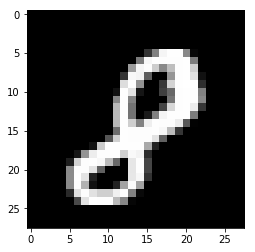

In [15]:
import torch
import torchvision
from torchvision import datasets, transforms
from itertools import cycle
import matplotlib.pyplot as plt

batch_size = 1

# train data set
train_dataset = datasets.MNIST('data',
               train=True,
               download=True,
               transform=transforms.ToTensor())

# test data set
test_dataset = datasets.MNIST('data',
               train=False,
               transform=transforms.ToTensor())

# train data generator
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True
)
train_loader_iter = cycle(train_loader) # cycles over the entire data set to generate the samples

# test data generator
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = True
)
test_loader_iter = iter(test_loader) # iterates over the entire data set only once

# generate a training data samples
_data, _label = train_loader_iter.next()
plt.imshow(_data.squeeze().numpy(), cmap='gray')
print 'data.size()\t\t', _data.size()
print 'label\t\t', _label.numpy()[0]